# Laboratorium 3: Augmentacje danych i balans klas (DermaMNIST)


**Cele:**
- porównać wpływ różnych **augmentacji** (geometria, intensywność, heavy) na wyniki,
- zastosować metody **balansu klas**: wagi w `CrossEntropy`, `WeightedRandomSampler`,
- przeprowadzić rzetelną **ewaluację** (Loss, Accuracy, Macro-Precision/Recall/F1, Confusion Matrix),
- zebrać wyniki w tabeli i wyciągnąć wnioski.

> **Dataset:** **DermaMNIST (MedMNIST)** – 7-klasowa klasyfikacja zmian skórnych, automatyczny download.

> Uwaga: architektura CNN będzie prosta (dla 28×28×3); skupiamy się na augmentacjach i balansie klas.

Augmentacja danych (ang. data augmentation) to zestaw technik sztucznego powiększania i urozmaicania zbioru treningowego poprzez modyfikacje istniejących danych. Istniejące próbki przekształca się tak, aby powstały ich różnorodne warianty, ale zachowujące tę samą etykietę (klasę). Przykłady dla obrazów:
- obrót, odbicie lustrzane, przycięcie, skalowanie, przesunięcie,
- zmiana jasności, kontrastu, koloru, dodanie szumu,
- losowe maskowanie fragmentów obrazu (Cutout, Random Erasing).

Stosowana jest ona w celu: zwiększenia rozmiaru zbioru treningowego – szczególnie ważne, gdy mamy mało przykładów, poprawy generalizacji – model uczy się odporniejszych cech (mniejszy overfitting), symulacji warunków rzeczywistych – różne oświetlenia, kąty patrzenia czy szumy w danych, wyrównania zbioru – generowanie dodatkowych przykładów dla klas, których jest mniej.

## 0) Instalacja i importy

In [ ]:
!pip -q install medmnist torchmetrics tqdm scikit-learn pandas

import os, random, math, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from tqdm.auto import tqdm

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, ConfusionMatrixDisplay)

import medmnist
from medmnist import DermaMNIST, INFO

SEED = 42
def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


## 1) Pobranie danych (DermaMNIST, MedMNIST) + szybki podgląd i rozkład klas

Skrypt automatycznie pobiera zbiór **DermaMNIST**. Poniższy kod sprawdza rozmiar danych i etykiety.
Wyświetlone zostaje również 6 pierwszych próbek z tego zbioru.

Zwróć uwagę na rozkład klas w wykorzystywanym zbiorze. Co można o nim powiedzieć?

Opis: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
Liczba klas: 7 ; label map: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
Rozmiary: 7007 1003 2005


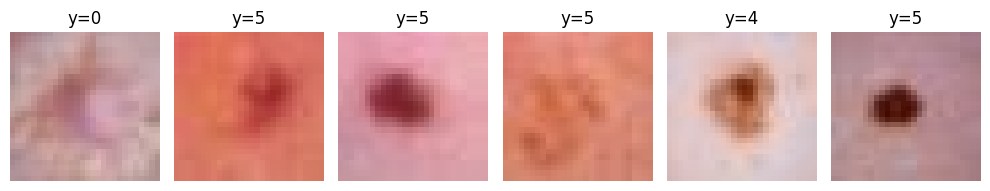

Rozkład klas (train): {0: 228, 1: 359, 2: 769, 3: 80, 4: 779, 5: 4693, 6: 99}


In [ ]:
DATA_ROOT = './data/dermamnist'
os.makedirs(DATA_ROOT, exist_ok=True)
info = INFO['dermamnist']
NUM_CLASSES = len(info['label'])
print('Opis:', info['description'])
print('Liczba klas:', NUM_CLASSES, '; label map:', info['label'])

# as_rgb=True -> 3 kanały
train_raw = DermaMNIST(split='train', download=True, root=DATA_ROOT, as_rgb=True)
val_raw   = DermaMNIST(split='val',   download=True, root=DATA_ROOT, as_rgb=True)
test_raw  = DermaMNIST(split='test',  download=True, root=DATA_ROOT, as_rgb=True)
print('Rozmiary:', len(train_raw), len(val_raw), len(test_raw))

# podgląd kilku przykładów
fig, axes = plt.subplots(1, 6, figsize=(10,2))
for i in range(6):
    img, y = train_raw[i]
    axes[i].imshow(np.array(img))
    axes[i].set_title(f'y={int(y.squeeze().item())}')
    axes[i].axis('off')
plt.tight_layout(); plt.show()

# Rozkład klas w train
vals, cnts = np.unique(train_raw.labels.squeeze(), return_counts=True)
print('Rozkład klas (train):', dict(zip(vals.tolist(), cnts.tolist())))

## Zadanie 1 – Dataset z przełączanymi augmentacjami i normalizacją

W następnym fragmencie kodu chcemy przygotować różn warianty augmentacji danych, które będą wykorzystane do uczenia sieci i porównania wyników. W tym celu korzystamy z klasy `transforms` z biblioteki `torchvision`.

1. Przygotuj najprostszą, bazową transformację danych. Zawiera ona przekształcenia, które będą obecne we wszystkich innych wariantach augmentacji.
2. Do stworzenia pojedynczego wariantu wykorzystujemy funkcję `transforms.Compose`. Przyjmuje ona listę transformacji, które powinny być wykonane na wczytywanych danych.
3. Podstawowy wariant powinien zawierać dwie transformacje: `transforms.ToTensor()` i `transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])`. Pierwsza z nich przekształca dane do typu tensora z PyTorch z odpowiednią kolejnością wymiarów. Dodatkowo dla obrazów typu `uint8` zmienia ich zakres do `[0.0, 1.0]`. Jeśli wejściem są wartości typu `float`, to zostaną one zachowane. Druga z kolei zmienia zakres danych do przedziału `[-1.0, 1.0]` (zakłądając, że wejście ma zakres `[0.0, 1.0]`). Jej arguemntami są paramtry normalizacji dla poszczególnych kanałów.
4. Stwórz transformację, która przed bazowymi wykona dodatkowo odbicie w poziomie `transforms.RandomHorizontalFlip` i rotację obrazu `transforms.RandomRotation`. Argumentem pierwszej jest prawdopodobieństwo odbicia, a drugiej maksymalny kąt rotacji w stopniach.
5. Stwórz transformację, która przed bazowymi wykona dodatkowo losową zmianę kolorów `transforms.ColorJitter`. Argumentami są maksymalne zmiany dla danej właściwości, np. `transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.02)`.
6. Czwarta transformacja powinna łączyć wszystkie wymienione wcześniej.
7. Napisz również funkcję `make_datasets`, która będzie tworzyć DataSet i aplikować transformacje przekazane jako argument do danych treningowych. Zwracać powinna 3 zbiory danych: treningowy, walidacyjny i testowy. Dla danych walidacyjnych i testowych stosujemy tylko podstawowy wariant transformacji. Transformacja jest przekazywana jako dodatkowy arguement podczas inicjalizacji obiektu klasy `DermaMNIST`.
8. Zdefiniuj `BATCH_SIZE`, `NUM_WORKERS` i `PIN_MEMORY`.

In [ ]:
# Zadanie 1
import torchvision

base_transform = torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

orientation_transform = torchvision.transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation([-90, 90])
])

color_transform = torchvision.transforms.Compose([
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.02)
])

full_transform = torchvision.transforms.Compose([
    base_transform,
    orientation_transform,
    color_transform
])

def make_datasets(base_transform, full_transform):
  train_data = DermaMNIST(split='train', download=True, root=DATA_ROOT, transform=full_transform, as_rgb=True)
  val_data = DermaMNIST(split='val', download=True, root=DATA_ROOT, transform=base_transform, as_rgb=True)
  test_data = DermaMNIST(split='test', download=True, root=DATA_ROOT, transform=base_transform, as_rgb=True)

  return train_data, val_data, test_data

BATCH_SIZE = 32
NUM_WORKERS = 2
PIN_MEMORY = True


## Zadanie 2 – Prosta sieć CNN 3-kanałowa + pętle trening/ewaluacja

Zdefniujmy bardzo podobną sieć do wykorzystanej w poprzednim tygodniu. Poniżej znajduje się lista modyfikacji koniecznych do wykonania.

1. Liczba kanałów wejściowych: 3.
2. Liczba kanałów wyjściowych pierwszej warstwy konwolucyjnej: 16.
3. Liczba kanałów wyjściowych drugiej warstwy konwolucyjnej: 32.
4. Rozmiar obu konwolucji wynosi 3, a padding 1.
5. Wyjście pierwszej warstwy w pełni połączonej ma rozmiar 128.
6. Liczba klas (a więc i rozmiar wyjścia sieci) powinna być podawana jako argument.
7. Dodajmy również warstwę dropout o prawdopodobieństwie równym 0.25 `nn.Dropout(p=0.25)` pomiędzy warstwami w pełni połączonymi. Warstwa ta losowo wyłącza część neuronów z zadanym prawdopodobieństwem. Warstwa taka może poprawić generalizację sieci i sprawić, że będzie się uczyć bardziej ogólnych cech.
8. Zaimplementuj funkcję, która będzie wykonywać jedną epokę treningu (podobnie jak w poprzednim ćwiczeniu). Jej argumentami są trenowana sieć, DataLoader, optimalizator i obiekt funkcji straty. Nie musi ona liczyć dokładności, bo zaimplementujemy osobną funkcję do ewaluacji.
9. Zaimplementuj funkcję wykonującą ewaluację sieci. Jak argumenty przyjmuje ona instancję sieci i DataLoader. Zapamiętaj w dwóch listach predykcje sieci i etykiety. Po przetworzeniu danych połącz je w jeden wektor za pomocą funkcji `np.concatenate` i oblicz metryki klasyfikacji takie jak: dokładność (accuracy), precyzja (precision), czułość (recall) i F1-score. W tym calu wykozystaj funkcje `accuracy_score`, `precision_score`, `recall_score` i `f1_score`.
    - Dokładność jest odsetkiem poprawnie sklasyfikowanych próbek.
    - Precyzja mówi ile z przewidzianych klasyfikacji danej klasy naprawdę należało do danej klasy. Dodajemy argument `average='macro`, który sprawia, że finalny wynik jest uśrednioną wartością dla wszystkich klas.
    - Czułość mówi ile z prawdziwych przykładów danej klasy zostało poprawnie znalezionych przez model. W tym przypadku również chcemy uśrednić wyniki dla wszystkich klas.
    - F1-score jest średnią harmoniczną z precyzji i czułości. Również chcemy go uśrednić dla wszystkich klas.
Na wyjście sieci przekaż słownik zawierający obliczone metryki, wektor predykcji sieci oraz wektor rzeczywistych etykiet.

Dlaczego w przypadku wykorzystywanego zbioru po prostu sprawdzanie dokładności może nie być dobrą metodą oceny jej skuteczności?
Ponieważ zbiór nie jest zbalansowany - klasa z czerniakiem jest znacznie liczniejsza niż inne

In [ ]:
# Zadanie 2
# --- Zadanie 9
class DermaCNN3D(nn.Module):
  def __init__(self, num_classes, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)

    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.fc1 = nn.Linear(64 * 7 * 7, 128)
    self.dropout = nn.Dropout(p=0.25)
    self.fc2 = nn.Linear(128, 256)
    self.fc3 = nn.Linear(256, num_classes)

  def forward(self, x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = x.view(-1, 64 * 7 * 7)  # Flatten
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'

derma_model = DermaCNN3D(num_classes=NUM_CLASSES)
derma_model.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(derma_model.parameters(), lr=0.001)

print(derma_model)

DermaCNN3D(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=7, bias=True)
)


In [ ]:
def run_epoch(model, loader, device, loss_func, optimizer=None):
    training_flag = optimizer is not None
    model.train(training_flag)

    total_loss = 0.0
    total_samples = 0

    for batch_imgs, batch_labels in loader:
        batch_imgs, batch_labels = batch_imgs.to(device), batch_labels.to(device)
        batch_labels = batch_labels.view(-1).long()

        if training_flag:
            optimizer.zero_grad()

        outputs = model(batch_imgs)
        loss = loss_func(outputs, batch_labels)

        if training_flag:
            loss.backward()
            optimizer.step()

        total_loss += loss  #.item() * batch_imgs.size(0)
        total_samples += batch_imgs.size(0)

    return (total_loss / total_samples).detach().cpu()


In [ ]:
def eval_model(model, loader, device):
  pred_list = np.array([])
  label_list = np.array([])

  # model.eval() # Set model to evaluation mode

  with torch.no_grad():
    for batch_imgs, batch_labels in loader:
      batch_imgs, batch_labels = batch_imgs.to(device), batch_labels.to(device)
      batch_labels = batch_labels.view(-1).long()

      outputs = model(batch_imgs)
      predicted = outputs.argmax(1)
      pred_list = np.concatenate((pred_list, predicted.cpu().detach().numpy()))
      label_list = np.concatenate((label_list, batch_labels.cpu().detach().numpy()))

    accuracy = accuracy_score(label_list, pred_list)
    precision = precision_score(label_list, pred_list, average='macro', zero_division=0)
    recall = recall_score(label_list, pred_list, average='macro', zero_division=0)
    f1 = f1_score(label_list, pred_list, average='macro')

  return {
      'accuracy': accuracy,
      'precision': precision,
      'recall': recall,
      'f1': f1
  }, torch.from_numpy(pred_list), torch.from_numpy(label_list)

## Zadanie 3 – Przeprowadzenie treningu i sprawdzenie augmentacji

Przeprowadź trening zdefiniowanej sieci dla każdego z wariantów augmentacji danych treningowych. Dla wielu przypadków testowych dobrze jest stworzyć strukturę zawierającą scenariusze testowe i uruchomić je w pętli.

1. Dla każdego pzypadku stwórz 3 DataSety z odpowiednimi transformacjami (użyj przygotowanej wcześniej funkcji), a następnie dla każdego z nich DataLoader.
2. Dla każdego przypadku stwórz instancję trenowanej sieci, optymalizator `torch.optim.Adam` i funkcję straty `nn.CrossEntropyLoss`.
3. Stwórz puste listy do śledzenia postępu treningu: `train_losses`, `val_losses`, `train_accuracies`, `val_accuracies`, `val_f1_scores`, `epochs_list`.
4. Dodatkowo chcemy zapamiętać model, który dla danego treningu osiągnął najlepszą wartość metryki F1-macro. Wymaga to zapamiętania najlepszej do tej pory widzianej metryki i poprawnej inicjalizacji.
5. Napisz pętlę trenującą. W każdej iteracji chcemy:
    - wykonać epokę treningu,
    - obliczyć i zapamiętać metryki dla zbioru treningowego,
    - obliczyć i zapamiętać metryki dla zbioru walidacyjnego,
    - obliczyć i zapamiętać stratę dla zbioru treningowego,
    - obliczyć i zapamiętać stratę dla zbioru walidacyjnego,
    - sprawdzić czy jest to najlepszy do tej pory model,
    - (opcjonalnie) wyświetlać wyniki po każdej epoce.
6. Po zakończonym treningu wyświetl 2 wykresy:
    - wykres staty dla zbioru treningowego i walidacyjnego,
    - wykres wyznaczonych metryk dla zbioru treningowego i walidayjnego.
7. Wykonaj ewaluację dla zbioru testowego. Wyświetl macierz pomyłek (podobnie jak w poprzednim ćwiczeniu).

Dobrze jest zapamiętywać wyniki metryki zbioru testowego dla wszystkich testowanych przypadków i wyświetlić je na końcu w formie tabeli.

torch.Size([32, 3, 28, 28])
torch.Size([32, 1])
DermaCNN3D(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=7, bias=True)
)
Epoch: 1/10
Train loss: 0.03246245160698891
Val loss: 0.028693079948425293
Train accuracy: 0.6727558156129585
Val accuracy: 0.6699900299102692
Val f1: 0.1196404184112977

Epoch: 2/10
Train loss: 0.029330868273973465
Val loss: 0.02761784754693508
Train accuracy: 0.6786071071785358
Val accuracy: 0.674975074775673
Val f1: 0.15114115067153663

Epoch: 3/10
Train loss: 0.0285539962351322

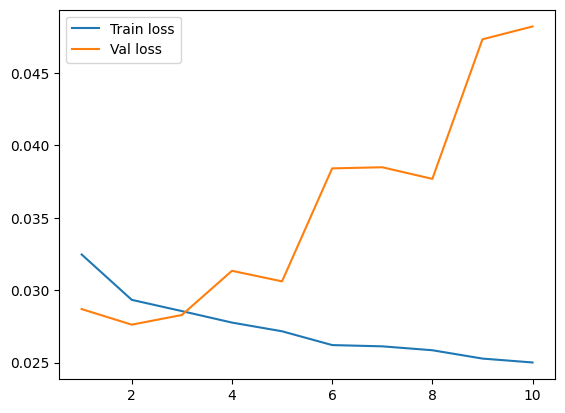

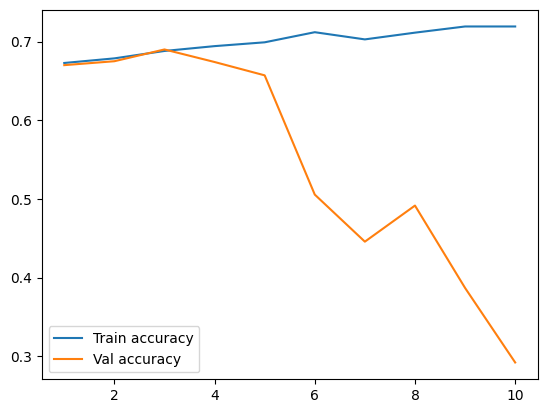

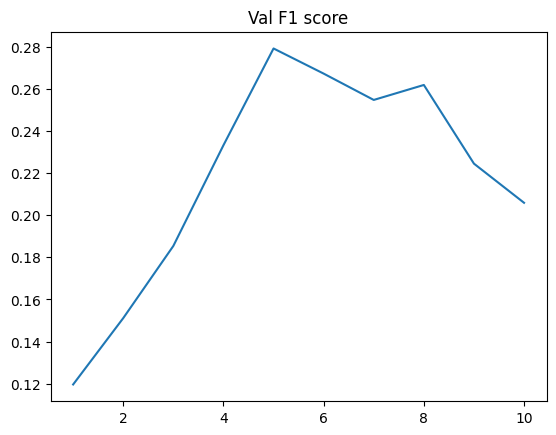

In [ ]:
# Zadanie 3
train_ds, val_ds, test_ds = make_datasets(base_transform, orientation_transform)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

for imgs, labels in train_dl:
  print(imgs.shape)
  print(labels.shape)
  break

derma_model = DermaCNN3D(num_classes=NUM_CLASSES)
derma_model.to(device)

LOSS_FUNC = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(derma_model.parameters(), lr=0.001)
EPOCHS = 10

print(derma_model)

def train(model, train_dl, val_dl, device, loss_func, optimizer):
  model.train(True)

  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []
  val_f1_scores = []
  epochs_list = []

  best_f1 = 0

  # Train loop
  for epoch in range(EPOCHS):
    train_loss = run_epoch(model, train_dl, device, loss_func, optimizer)
    val_loss = run_epoch(model, val_dl, device, loss_func)

    train_metrics, _, _ = eval_model(model, train_dl, device)
    val_metrics, _, _ = eval_model(model, val_dl, device)

    train_accuracies.append(train_metrics['accuracy'])
    val_accuracies.append(val_metrics['accuracy'])
    val_f1_scores.append(val_metrics['f1'])
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    epochs_list.append(epoch+1)

    if val_metrics['f1'] > best_f1:
      best_f1 = val_metrics['f1']
      torch.save(model.state_dict(), 'best_zad3_model.pth')

    print(f'Epoch: {epoch+1}/{EPOCHS}')
    print(f'Train loss: {train_loss}')
    print(f'Val loss: {val_loss}')
    print(f'Train accuracy: {train_metrics["accuracy"]}')
    print(f'Val accuracy: {val_metrics["accuracy"]}')
    print(f'Val f1: {val_metrics["f1"]}')
    print()

  plt.plot(epochs_list, train_losses, label='Train loss')
  plt.plot(epochs_list, val_losses, label='Val loss')
  plt.legend()
  plt.show()
  plt.plot(epochs_list, train_accuracies, label='Train accuracy')
  plt.plot(epochs_list, val_accuracies, label='Val accuracy')
  plt.legend()
  plt.show()
  plt.plot(epochs_list, val_f1_scores, label='Val f1')
  plt.title("Val F1 score")
  plt.show()

train(derma_model, train_dl, val_dl, device, loss_func, optimizer)
# test_metrics, _, _ = eval_model(derma_model, test_dl, device)

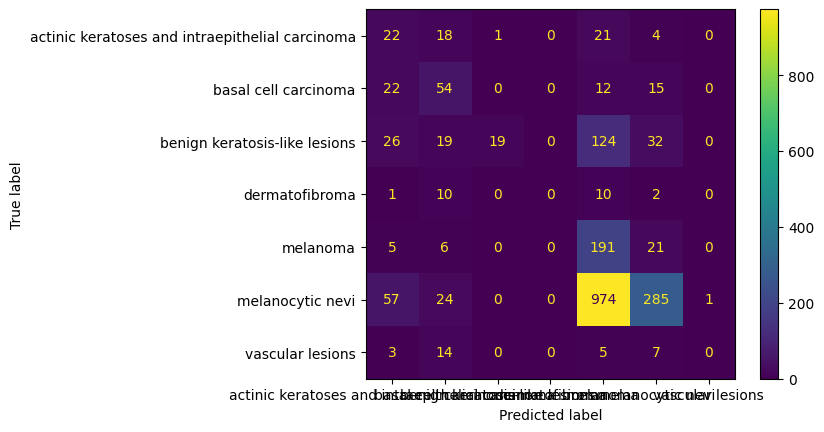

Test accuracy: 0.28478802992518704
Test precision: 0.34367488091901544
Test recall: 0.2875712886736353
Test f1: 0.19863284825226438


In [ ]:
def test_model(model, num_classes, test_dl, ds_info, device):

  test_metrics, test_preds, test_labels = eval_model(model, test_dl, device)

  cm = np.zeros((num_classes, num_classes), dtype=int)  # macierz pomyłek
  cm += confusion_matrix(test_labels.numpy(), test_preds.numpy(), labels=np.array(list(ds_info['label'].keys())).astype(int))

  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(ds_info['label'].values()))
  cm_display.plot()
  plt.show()

  print(f'Test accuracy: {test_metrics["accuracy"]}')
  print(f'Test precision: {test_metrics["precision"]}')
  print(f'Test recall: {test_metrics["recall"]}')
  print(f'Test f1: {test_metrics["f1"]}')

test_model(derma_model, NUM_CLASSES, test_dl, info, device)

## Zadanie 4 – Balans klas: wagi, WeightedRandomSampler

Wykorzystamy dodatkowo dwie metody radzenia sobie ze zbiorami danych i niezbalansowanych klasach.
Pierwszą są wagi klas (class weights). Działa to w ten sposób, że jeśli jakaś klasa jest rzadka, to jej błędy mają być bardziej kosztowne. Dodając większe wagi dla rzadkich klas w funkcji straty, uczymy model, żeby przykładał do nich większą wagę.

Drugą metodą jest zmiana doboru próbek (WeightedRandomSampler). W tym przypadku rzadkie klasy są częściej losowane do batcha, a więc model widzi ich proporcjonalnie więcej. Również w tym przypadku tworzymy wagi dla każdej klasy.

1. Zaimplementuj funkcję, która będzie obliczać wagi dla klas. Jej argumentem jest lista rzeczywistych etykiet zbioru treningowego (metoda `.labels` dla zbioru treningowego).
2. Wewnątrz funkcji sprawdzamy ile jest wystąpień dla każdej etykiety (funkcja `np.unique`). Jej pierwszym argumentem są etykiety. Przekazujemy jej również argument `return_counts=True`, który powoduje, że funkcja zwraca również liczbę wystąpień.
3. Następnie dzielimy otrzymane wystąpienia przez liczbę próbek. W ten sposób obliczamy częstość występowania danej klasy.
4. Chcemy, aby waga była odwrotnie proporcjonalna do częstości jej występowania, a więc obliczamy odwrotność poprzedniej wartości. Warto dodać zabezpieczenie przed zbyt małą wartością mianownika `np.maximum(freq, 1e-8)`.
5. Normalizujemy wartości obliczonych wag tak, żeby ich suma wynosiła liczbę możliwych etykiet.
6. Zwracamy tensor wag `torch.tensor` z danymi typu `torch.float32`.
7. Wyświetl obliczone wagi.
8. Na podstawie wag zwróconych przez zaimplementowaną funkcję stworzymy sampler do danych treningowych. W tym celu należy obliczyć wagę dla każdej próbki ze zbioru treningowego. Bierzemy więc listę etykiet próbek i sprawdzamy jakie prawdopodobieństwo odpowiada każdej z nich (a więc robimy Look-Up Table).
9. Obliczone nagi dla każdej próbki przezkazujemy do klasy `WeightedRandomSampler` jako argument `weights`. Oprócz tego konieczne jst przekazanie argumentu `num_samples`, czyli liczba próbek, i podanie argumentu `replacement` jako `True`.

In [ ]:
# Zadanie 4
def get_class_weights(labels):
  unique_labels, counts = np.unique(labels, return_counts=True)
  freq = counts / np.sum(counts)
  weights = 1 / np.maximum(freq, 1e-8)
  weights = weights / np.sum(weights)
  return torch.tensor(weights, dtype=torch.float32)

train_ds, val_ds, test_ds = make_datasets(base_transform, full_transform)

weights = get_class_weights(train_ds.labels)
print(weights)
sample_weights = torch.from_numpy(np.array([weights[label] for label in train_ds.labels.flatten()]))

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_ds), replacement=True)

tensor([0.1347, 0.0855, 0.0399, 0.3838, 0.0394, 0.0065, 0.3101])


## Zadanie 5 – Przeprowadzenie treningu i sprawdzenie wpływu testowanych metod na wynik

Przeprowadzamy trening podobno do zadania 3, ale tym razem zamiast metod augumentacji sprawdzamy wpływ wag strat i częstości doboru próbek.

1. Aby sprawdzić wpływ wag, do funkcji straty należy przekazać ich wektor `nn.CrossEntropyLoss(weight=weights_ce.to(device))`.
2. Aby sprawdzić wpływ samplera, należy go przekazać do DataLoadera jako argument `sampler`.
3. Sprawdź wpływ zaimplementowanych metod na wyniki treningu przeprowadzając eksperymenty w podobny sposób jak w zadaniu 3.

Epoch: 1/10
Train loss: 0.044995833188295364
Val loss: 0.08423960208892822
Train accuracy: 0.21549878692735835
Val accuracy: 0.023928215353938187
Val f1: 0.014352899057785877

Epoch: 2/10
Train loss: 0.03904232382774353
Val loss: 0.07768570631742477
Train accuracy: 0.26173826173826176
Val accuracy: 0.0259222333000997
Val f1: 0.0206537949235888

Epoch: 3/10
Train loss: 0.03537373244762421
Val loss: 0.07535482943058014
Train accuracy: 0.29641786784643925
Val accuracy: 0.03290129611166501
Val f1: 0.036877117561834497

Epoch: 4/10
Train loss: 0.03232894837856293
Val loss: 0.07156529277563095
Train accuracy: 0.3400884829456258
Val accuracy: 0.04685942173479561
Val f1: 0.06976970219265193

Epoch: 5/10
Train loss: 0.02919522114098072
Val loss: 0.0749073177576065
Train accuracy: 0.3709147994862281
Val accuracy: 0.047856430707876374
Val f1: 0.06104751819566912

Epoch: 6/10
Train loss: 0.02627601847052574
Val loss: 0.06599057465791702
Train accuracy: 0.40002854288568573
Val accuracy: 0.076769690

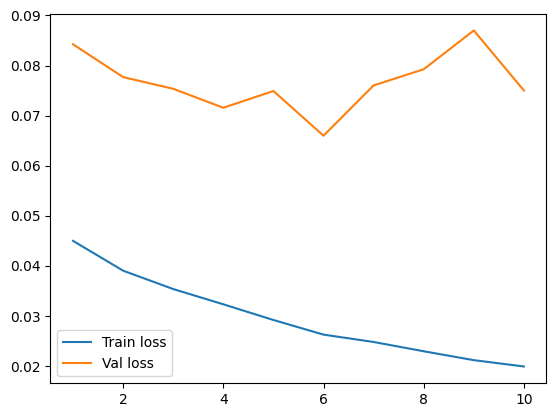

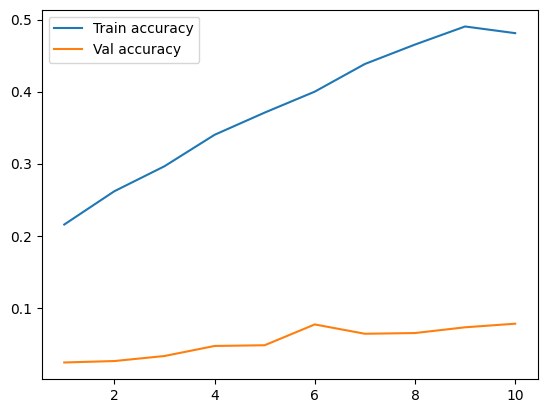

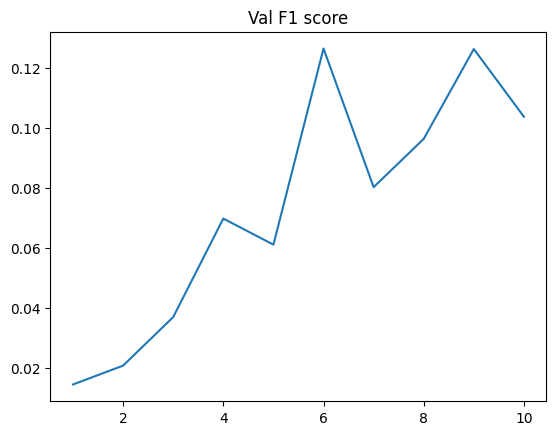

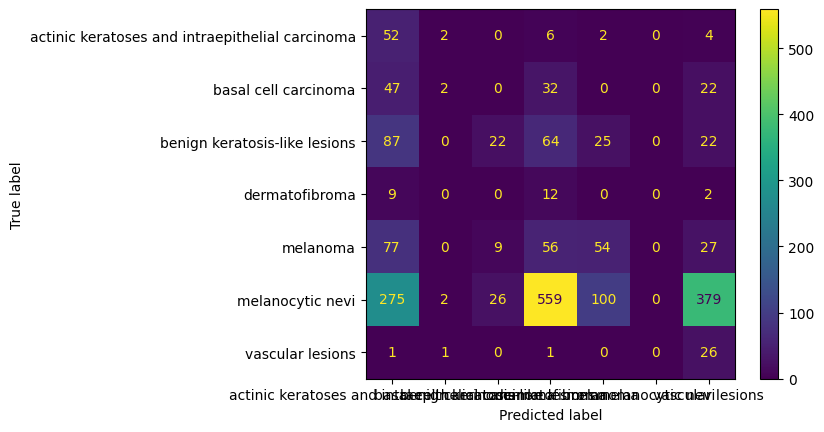

Test accuracy: 0.08379052369077307
Test precision: 0.16218464503691904
Test recall: 0.3668199406496243
Test f1: 0.10936428632543771


In [ ]:
# Zadanie 5
weight_model = DermaCNN3D(num_classes=NUM_CLASSES)
weight_model.to(device)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False, sampler=sampler)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False)

LOSS_FUNC = nn.CrossEntropyLoss(weight=weights.to(device))
OPTIMIZER = torch.optim.Adam(weight_model.parameters(), lr=0.001)
EPOCHS = 10

train(weight_model, train_dl, val_dl, device, LOSS_FUNC, OPTIMIZER)
test_model(weight_model, NUM_CLASSES, test_dl, info, device)

## Zadanie 6 – Eksperymenty własne

Spróbuj połączyć poznane metody tak, aby uzysać jak największy wskaźnik F1-macro. Możesz dodatkowo użyć innych metod augmentacji danych, takich jak: `transforms.RandomVerticalFlip`, `transforms.RandomAffine`, `transforms.RandomResizedCrop`, `transforms.GaussianBlur`, `transforms.RandomApply`, `transforms.RandomAdjustSharpness`, `transforms.RandomGrayscale`, `transforms.RandomErasing`, `transforms.Lambda` (może zostać użyte do uzyskania szumu Gaussowskiego: `transforms.Lambda(lambda x: torch.clamp(x + 0.03*torch.randn_like(x), -1, 1))`, w tej formie używana już po normalizacji zakresu), `transforms.TrivialAugmentWide`, `transforms.RandAugment`.

Pochwal się uzyskanym wynikiem.

Epoch: 1/10
Train loss: 0.04621078819036484
Val loss: 0.08808756619691849
Train accuracy: 0.21207364064506923
Val accuracy: 0.015952143569292122
Val f1: 0.009692060469591412

Epoch: 2/10
Train loss: 0.03974785655736923
Val loss: 0.08886443078517914
Train accuracy: 0.25488796917368345
Val accuracy: 0.01794616151545364
Val f1: 0.01708405329471132

Epoch: 3/10
Train loss: 0.036991752684116364
Val loss: 0.09768420457839966
Train accuracy: 0.2594548308834023
Val accuracy: 0.023928215353938187
Val f1: 0.019448339476322827

Epoch: 4/10
Train loss: 0.03474260866641998
Val loss: 0.1061709001660347
Train accuracy: 0.29898672755815614
Val accuracy: 0.028913260219341975
Val f1: 0.03984497509242061

Epoch: 5/10
Train loss: 0.032877154648303986
Val loss: 0.09209898114204407
Train accuracy: 0.34180105608677036
Val accuracy: 0.031904287138584245
Val f1: 0.05065590081918442

Epoch: 6/10
Train loss: 0.030210990458726883
Val loss: 0.11318647861480713
Train accuracy: 0.3723419437705152
Val accuracy: 0.036

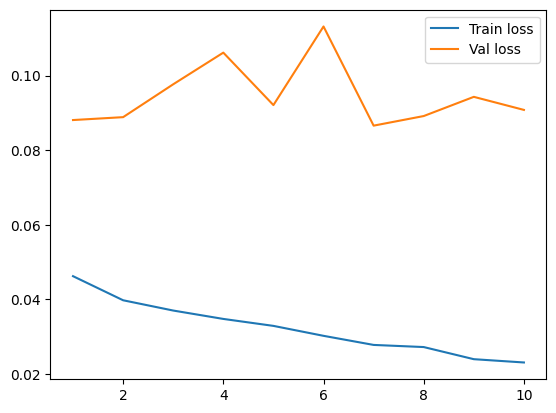

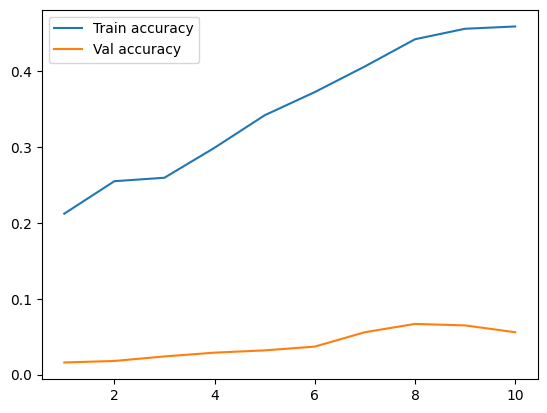

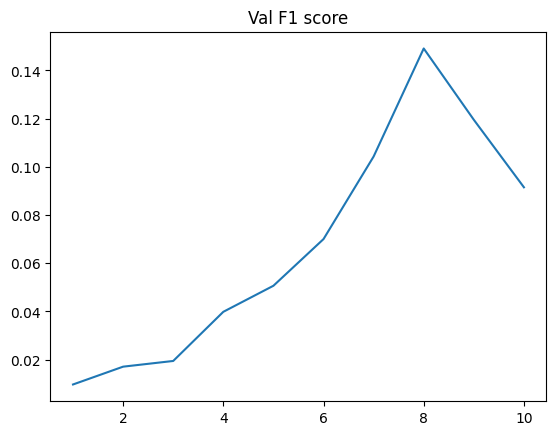

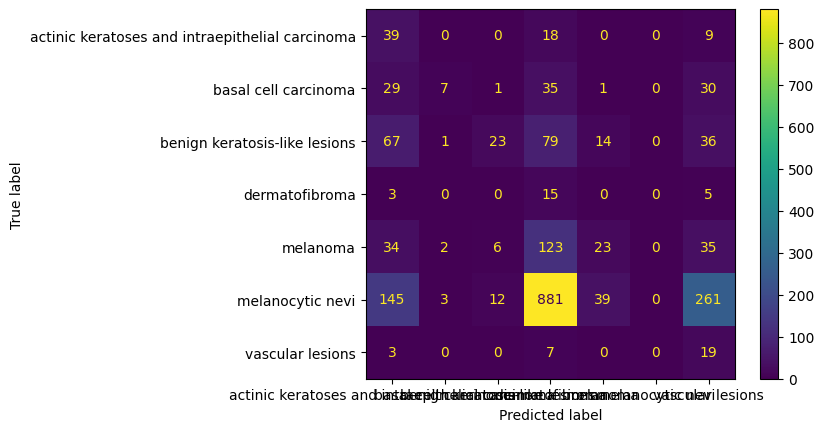

Test accuracy: 0.0628428927680798
Test precision: 0.22395878835433103
Test recall: 0.31055729297036944
Test f1: 0.10952755564048376


In [ ]:
# Zadanie 6
model = DermaCNN3D(num_classes=NUM_CLASSES)
model.to(device)

LOSS_FUNC = nn.CrossEntropyLoss(weight=weights.to(device))
OPTIMIZER = torch.optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 10

base_transform = torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

orientation_transform = torchvision.transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30)
])

color_transform = torchvision.transforms.Compose([
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.02)
])

additional_transforms = torchvision.transforms.Compose([
    transforms.Lambda(lambda x: torch.clamp(x + 0.03*torch.randn_like(x), -1, 1)),  # Gaussian Noise
    transforms.GaussianBlur(kernel_size=(3, 5), sigma=(0.1, 5)),  # Gaussian Blur
    transforms.RandomVerticalFlip(p=0.5)  # Vertical Flip
])

full_transform = torchvision.transforms.Compose([
    base_transform,
    orientation_transform,
    color_transform,
    additional_transforms
])

train_ds, val_ds, test_ds = make_datasets(base_transform, full_transform)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False)

train(model, train_dl, val_dl, device, LOSS_FUNC, OPTIMIZER)
test_model(model, NUM_CLASSES, test_dl, info, device)

## Podsumowanie – Wnioski

- Która strategia **augmentacji** dała najwyższą Macro-F1?
- Czy **wagi** w CE lub **sampler** poprawiły Recall klas rzadkich?
- Jakie klasy najczęściej się mylą (macierz pomyłek)?